In [1]:
import re
import numpy as np
import scipy.stats as sts

from matplotlib import pyplot as plt

%matplotlib notebook

In [3]:
def read_clusters(fp):
    """Read in clusters from clusters.csv and build a dictionary."""
    clusters = {}
    
    for line in fp:
        if line.startswith('Cluster'):
            continue
        _, kind, scaffold, start, end, size = line.strip().split(',')
        
        cluster = {
            "type": kind,
            "start": int(start),
            "end": int(end),
            "size": int(size)
        }
        
        if scaffold in clusters:
            clusters[scaffold].append(cluster)
        else:
            clusters[scaffold] = [cluster]
            
    return clusters

In [4]:
def read_genome(fp):
    """Read in genome from FASTA file."""
    sequences = {}
    
    sequence = ""
    header = ""
    
    for line in fp:
        if "mito" in line:
            break
        if line.startswith(">"):
            # New sequence, so save the previous one before getting the new header
            if header and sequence:
                sequences[header] = sequence
            header = line.split()[0].replace(">", "")
            sequence = ""
        else:
            sequence += line.strip()
            
    # Add the final sequence
    if header and sequence:
        sequences[header] = sequence
        
    return sequences

Read in clusters.csv and genome assembly FASTA from fungiDB (FungiDB-46_AnidulansFGSCA4_Genome.fasta).

In [5]:
with open("clusters.csv") as fp:
    clusters = read_clusters(fp)
    
with open("FungiDB-46_AnidulansFGSCA4_Genome.fasta") as fp:
    sequences = read_genome(fp)

In [7]:
def parse_gff(fp):
    """Parse a GFF3 file for gene features."""
    
    scaffolds = {}
    features = []
    
    previous = None  # Store previous scaffold
    
    # Regex pattern for pulling ID features from notes field
    pattern = re.compile('ID=(?:\w+?_)?(AN\d+)')
    
    for line in fp:
        if line.startswith("#"):
            continue
            
        scaffold, _, kind, start, end, _, strand, _, notes = line.split("\t")
        
        if scaffold not in scaffolds:
            scaffolds[scaffold] = []
        
        if kind == "gene":
            # New gene feature, all following features should be linked to this one until next gene
            if features:
                scaffolds[previous].append(features)
                features = []
            
        try:
            name = pattern.search(notes).group(1)
        except AttributeError:
            continue
                        
        feature = {
            "id": name,
            "type": kind,
            "start": int(start),
            "end": int(end),
            "strand": strand
        }
        
        previous = scaffold
            
        features.append(feature)
            
    return scaffolds

In [9]:
with open("FungiDB-46_AnidulansFGSCA4.gff") as fp:
    scaffolds = parse_gff(fp)
    
total = sum(
    len(genes)
    for genes in scaffolds.values()
)

print(f"Found {total} genes")

Found 10778 genes


Find all genes within gene cluster boundaries from JGI.

In [11]:
def overlaps_range(start, end, gene):
    """Check gene is within range.
    
    1. Gene overlaps left
    2. Gene overlaps right
    3. Range contains gene
    4. Gene contains range
    """
    return (
        gene['start'] <= start <= gene['end'] <= end or
        start <= gene['start'] <= end <= gene['end'] or
        start <= gene['start'] <= gene['end'] <= end or
        gene['start'] <= start <= end <= gene['end']
    )

In [18]:
groups = {}

for scaffold, klusters in clusters.items():
    genes = sorted(scaffolds[scaffold], key=lambda x: x[0]["start"])

    for cluster in klusters:
        inside = False
        
        location = "{}:{}-{}".format(
            scaffold,
            cluster['start'],
            cluster['end']
        )
        
        groups[location] = []
        
        for features in genes:                
            gene = features[0]
            
            if overlaps_range(cluster['start'], cluster['end'], gene):
                inside = True
                
            if inside:
                # Make sure we don't save genes overlapping cluster border
                # when our inside flag is still True
                if not overlaps_range(cluster['start'], cluster['end'], gene):
                    break
                    
                groups[location].append(features)

In [61]:
def find_five_UTR(gene):
    """Find 5'UTR feature in a collection of gene features.
    If no feature is found, return 0.
    """
    for feature in gene:   
        if feature['type'] == 'five_prime_UTR':
            return feature['end'] - feature['start']
    return 0

In [87]:
def summarize_genes(handle, collection):
    """Write summary of genes in a collection to file."""
    for key, value in collection.items():
        for features in value:
            gene = features[0]
            utr = find_five_UTR(features)
            
            handle.write(
                "{},{},{},{},{},{}\n".format(
                    key,
                    gene["id"],
                    gene["start"],
                    gene["end"],
                    gene["strand"],
                    utr
                )
            )

In [89]:
# Summarize all genes
with open("five_prime_UTRs_genome.csv", "w") as fp:
    fp.write("Scaffold,ID,Start,End,Strand,5'UTR\n")
    summarize_genes(fp, scaffolds)
    
# Just those within BGCs
with open("five_prime_UTRs_bgcs.csv", "w") as fp:
    fp.write("Cluster,ID,Start,End,Strand,5'UTR\n")
    summarize_genes(fp, groups)

In [20]:
# Generate UTR array for all genes
all_utrs = [
    find_five_UTR(features)
    for genes in scaffolds.values()
    for features in genes
]

# Only those in putative BGCs
bgc_utrs = [
    find_five_UTR(features)
    for genes in groups.values()
    for features in genes
]

<IPython.core.display.Javascript object>


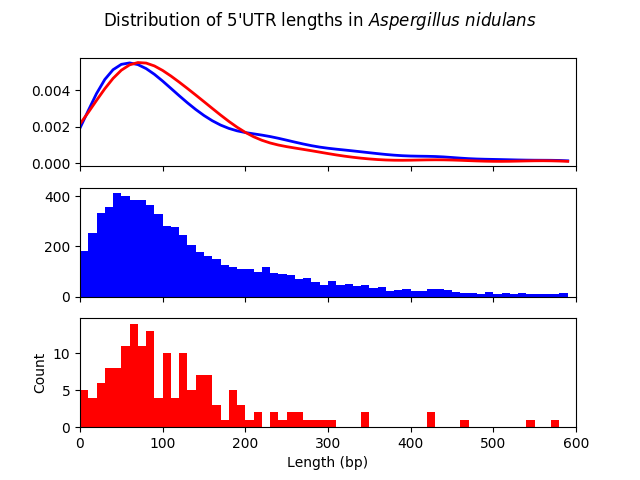

In [23]:
fig, ax = plt.subplots(3, 1, sharex=True)

bins = np.arange(0, 600, 10)

# Remove any UTR value < 0 or > 1000
all_filtered = [utr for utr in all_utrs if 0 < utr < 600]
bgc_filtered = [utr for utr in bgc_utrs if 0 < utr < 600]

# Plot histograms
ax[1].hist(all_filtered, bins=bins, color='blue', label='Whole genome')
ax[2].hist(bgc_filtered, bins=bins, color='red', label='Biosynthetic genes')

# Plot kernel density estimation curves
all_kde = sts.gaussian_kde(all_filtered)
bgc_kde = sts.gaussian_kde(bgc_filtered)
ax[0].plot(bins, all_kde.pdf(bins), c='blue', lw=2, label='Whole genome')
ax[0].plot(bins, bgc_kde.pdf(bins), c='red', lw=2, label='Biosynthetic genes')

# Adjust the figure
plt.suptitle("Distribution of 5'UTR lengths in $\it{Aspergillus\ nidulans}$")
plt.xlabel("Length (bp)")
plt.ylabel("Count")
plt.xlim(0, 600)
plt.xticks(np.arange(0, 601, 100))
plt.savefig("5UTR_length_distribution.svg")
plt.show()

In [93]:
## Use all genes
#all_filtered = np.array(all_utrs)
#bgc_filtered = np.array(bgc_utrs)

## Use all genes with 5'UTR > 0bp
#all_filtered = all_filtered[np.where(all_filtered > 0)]
#bgc_filtered = bgc_filtered[np.where(bgc_filtered > 0)]

## Use filtered arrays from last cell (0 - 600bp)
# calculate 5' UTR length mean/median
# whole genome
all_mean = np.mean(all_filtered)
all_med = np.median(all_filtered)

# in bgc
bgc_mean = np.mean(bgc_filtered)
bgc_med = np.median(bgc_filtered)

# below 100bp
# whole genome
all_arr = np.array(all_filtered)
all_pct = all_arr[np.where(all_arr < 100)].size / len(all_filtered)

# in bgc
bgc_arr = np.array(bgc_filtered)
bgc_pct = bgc_arr[np.where(bgc_arr < 100)].size / len(bgc_filtered)

print("Whole genome")
print("Mean: ", all_mean)
print("Median: ", all_med)
print(f"<100bp: {all_pct:.2%}")
print("\nBiosynthetic genes")
print("Mean: ", bgc_mean)
print("Median: ", bgc_med)
print(f"<100bp: {bgc_pct:.2%}")

Whole genome
Mean:  137.9158755659413
Median:  100.0
<100bp: 49.74%

Biosynthetic genes
Mean:  118.60625
Median:  90.5
<100bp: 52.50%


Count UTR features in all genes/genes in biosynthetic gene clusters.

In [94]:
def count_UTR_features(genes):
    """Count number of genes with and without five_prime_UTR features."""
    count = 0
    for features in genes:
        for feature in features:
            if feature["type"] == "five_prime_UTR":
                count += 1
                break
    return count, len(genes)     

In [95]:
def count_UTRS(gene_lists):
    """Wrapper around count_UTR_features for multiple gene sets.
    Use e.g. scaffolds.values()
    """
    total_utrs, total_genes = 0, 0
    for genes in gene_lists:
        utrs, total = count_UTR_features(genes)
        total_utrs += utrs
        total_genes += total
    return total_utrs, total_genes

In [96]:
all_utrs, all_genes = count_UTRS(scaffolds.values())
bgc_utrs, bgc_genes = count_UTRS(groups.values())

all_pct = all_utrs / all_genes
bgc_pct = bgc_utrs / bgc_genes

print(f"{all_utrs}/{all_genes} genes with 5'UTR features in whole genome ({all_pct:.2%})")
print(f"{bgc_utrs}/{bgc_genes} biosynthetic genes with 5'UTR features ({bgc_pct:.2%})")

7072/10778 genes with 5'UTR features in whole genome (65.62%)
163/396 biosynthetic genes with 5'UTR features (41.16%)


Extract sequences upstream of the start of the first CDS of each gene.

In [97]:
def get_upstream_ranges(genes, border='tss', distance=400):
    """Compute region upstream of first CDS (up to -600bp)."""
    total = len(genes)
    
    ranges = {}
    neighbour = None
    
    for index, features in enumerate(genes):
        
        gene = features[0]  # Get current 'gene' type feature
        name = gene['id']
        
        # Get the previous or next gene feature, if positive or negative strand, respectively
        if gene['strand'] == "+":
            n_index = index - 1
        else:
            n_index = index + 1
        
        # Account for genes on scaffold edges (i.e. have no neighbour on whichever side)
        try:
            neighbour = genes[n_index][0]
        except IndexError:
            print("Error finding neighbour for:", gene["id"])
            continue
            
        cds = [f for f in features if f['type'] == 'CDS']
        
        # Account for non-coding genes
        if not cds:
            print("No CDS features for:", gene["id"])
            continue

        # Compute the 5' upstream ranges.
        # If positive, save maximum of CDS start - 600bp or distance from previous gene end
        # If negative, save minimum of CDS end (actually coding start) + 600bp or distance to next gene
        # This ensures we do not cut into the previous/next feature.
        if gene['strand'] == "+":
            if border == "tss":
                start = gene["start"]
            elif border == "cds":
                start = min(f['start'] for f in features if f['type'] == 'CDS') - 100
            ranges[name] = [max(start - distance, start - neighbour['end']), start]
        else:
            if border == "tss":
                start = gene['end']
            elif border == "cds":
                start = max(f['end'] for f in features if f['type'] == 'CDS') + 100
            ranges[name] = [start, min(start + distance, start + neighbour['start'])]
        
    return ranges

In [98]:
ranges = {}

for scaffold, genes in scaffolds.items():
    if "mito" in scaffold:
        continue
    ranges.update(get_upstream_ranges(genes, border="cds"))

Error finding neighbour for: AN3102
Error finding neighbour for: AN1606
Error finding neighbour for: AN7561


In [99]:
def find_pattern(query, pattern, end=False):
    if end:
        return [match.end() + 1 for match in re.finditer(pattern, query)]
    return [match.start() + 1 for match in re.finditer(pattern, query)]

In [100]:
def find_pam_sites(sequence, strand, cas=12, loose=False):
    """Get positions of PAM sites in upstream sequences.
    If positive strand, look for TTTV, otherwise VAAA (so no need to reverse complement the sequence).
    """
    length = len(sequence)
    
    if cas == 12:
        forward = find_pattern(sequence, "TTT[ACG]")
        reverse = find_pattern(sequence, "[TCG]AAA", end=True)
        
        if loose:
            forward += find_pattern(sequence, "TTC[ACGT]")
            reverse += find_pattern(sequence, "[ACGT]GAA", end=True)
            
    elif cas == 9:
        forward = find_pattern(sequence, "[ACGT]GG")
        reverse = find_pattern(sequence, "CC[ACGT]", end=True)
    
    if strand == "+":
        # Since we want distance from the CDS, not index in the sequence excerpt
        forward = [length - value for value in forward]
        reverse = [length - value for value in reverse]
    
    return forward + reverse

In [101]:
def count_pam_sites(genes, cas=12, loose=False):
    """Count PAM site start position frequencies in a collection of genes."""
    counts = {}
    per_gene = {}
    
    for features in genes:
        gene = features[0]
        name = gene['id']
        
        try:
            start, end = ranges[name]
        except KeyError:
            continue
    
        sequence = sequences[scaffold][start: end]

        count = 0
        for position in find_pam_sites(sequence, gene['strand'], cas=cas, loose=loose):
            if position in counts:
                counts[position] += 1
            else:
                counts[position] = 1
            count += 1
        
        if count in per_gene:
            per_gene[count] += 1
        else:
            per_gene[count] = 1
    
    return per_gene, counts

In [102]:
def flatten_counts(counts):
    """Flatten dictionary of counts to redundant array.
    i.e. {100: 5} -> [100, 100, 100, 100, 100] 
    """
    flat = []
    for position, count in counts.items():
        flat.extend([position] * count)
    return flat

In [103]:
def update_counts(old, new):
    """Update counts stored in dictionary with values in another."""
    for k, v in new.items():
        try:
            old[k] += v
        except KeyError:
            old[k] = v      

Count PAM sites (TTTV and TTCN) in all genes.

In [104]:
all_counts, all_counts_loose = {}, {}
all_per_gene, all_per_gene_loose = {}, {}

for scaffold, genes in scaffolds.items():
    # Per gene, total count
    pg, cnt = count_pam_sites(genes)
    
    # Add new counts to old counts
    update_counts(all_per_gene, pg)
    update_counts(all_counts, cnt)
    
    # Repeat for loose sites
    pgl, cntl = count_pam_sites(genes, loose=True)
    update_counts(all_per_gene_loose, pgl)
    update_counts(all_counts_loose, cntl)

# Flatten count dictionary to array
all_count_list = flatten_counts(all_counts)

Now count them just in biosynthetic genes.

In [105]:
bgc_counts, bgc_counts_loose = {}, {}
bgc_per_gene, bgc_per_gene_loose = {}, {}

for location, genes in groups.items():
    scaffold = location.split(':')[0]
    
    # Regular sites
    pg, cnt = count_pam_sites(genes)
    update_counts(bgc_per_gene, pg)
    update_counts(bgc_counts, cnt)

    # Loose sites
    pgl, cntl = count_pam_sites(genes, loose=True)
    update_counts(bgc_per_gene_loose, pgl)
    update_counts(bgc_counts_loose, cntl)

bgc_count_list = flatten_counts(bgc_counts)

Now do the same for Cas9 (NGG).

In [106]:
# All genes
ngg_all_counts, ngg_all_per_gene = {}, {}
for scaffold, genes in scaffolds.items():
    pg, cnt = count_pam_sites(genes, cas=9)
    update_counts(ngg_all_per_gene, pg)
    update_counts(ngg_all_counts, cnt)

# BGC genes
ngg_bgc_counts, ngg_bgc_per_gene = {}, {}
for location, genes in groups.items():
    scaffold = location.split(':')[0]
    pg, cnt = count_pam_sites(genes, cas=9)    
    update_counts(ngg_bgc_per_gene, pg)
    update_counts(ngg_bgc_counts, cnt)

# Create flat arrays
ngg_all_count_list = flatten_counts(ngg_all_counts)
ngg_bgc_count_list = flatten_counts(ngg_bgc_counts)

Plot Cas9 and Cas12a PAM site histograms.

<IPython.core.display.Javascript object>


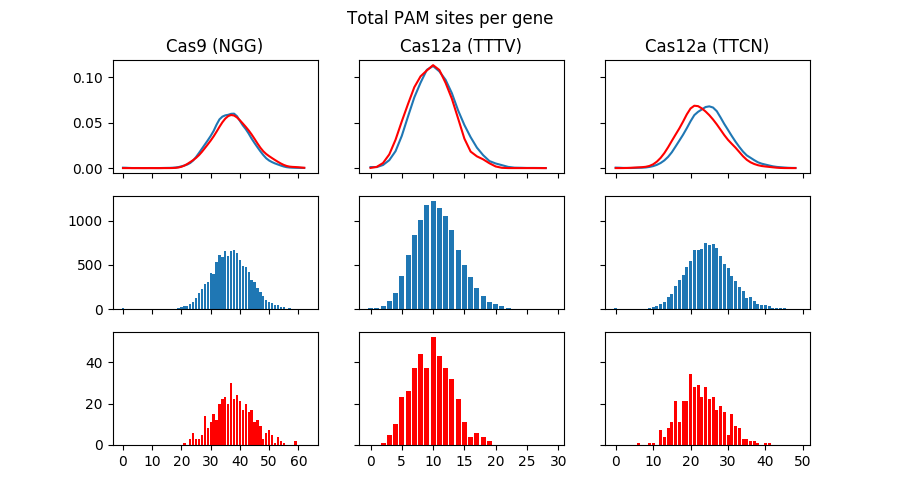

In [107]:
fig, ax = plt.subplots(3, 3, figsize=(9, 5), sharey="row", sharex="col")

### Cas9 plots

# Generate 'histograms' by plotting as bar charts
ax[1, 0].bar(list(ngg_all_per_gene), ngg_all_per_gene.values())
ax[2, 0].bar(list(ngg_bgc_per_gene), ngg_bgc_per_gene.values(), color="red")

# Flatten per gene dictionaries
ngg_all_flat_pg = flatten_counts(ngg_all_per_gene)
ngg_bgc_flat_pg = flatten_counts(ngg_bgc_per_gene)

# Generate 'bins' for histogram, 1 per count
bins = np.arange(max(ngg_all_flat_pg))

# KDE
ngg_all_kde_pg = sts.gaussian_kde(ngg_all_flat_pg)
ngg_bgc_kde_pg = sts.gaussian_kde(ngg_bgc_flat_pg)

# Plot curves to same axes
ax[0, 0].plot(bins, ngg_all_kde_pg(bins))
ax[0, 0].plot(bins, ngg_bgc_kde_pg(bins), color="red")


### Cas12a plots

# Histograms
ax[1, 1].bar(list(all_per_gene), all_per_gene.values())
ax[2, 1].bar(list(bgc_per_gene), bgc_per_gene.values(), color="red")

# KDE
all_flat_pg = flatten_counts(all_per_gene)
bgc_flat_pg = flatten_counts(bgc_per_gene)
bins = np.arange(max(all_flat_pg))
all_kde_pg = sts.gaussian_kde(all_flat_pg)
bgc_kde_pg = sts.gaussian_kde(bgc_flat_pg)

# Plot curves
ax[0, 1].plot(bins, all_kde_pg(bins))
ax[0, 1].plot(bins, bgc_kde_pg(bins), color="red")


### Now plot the 'loose' versions

# Flatten counts
all_flat_pg_loose = flatten_counts(all_per_gene_loose)
bgc_flat_pg_loose = flatten_counts(bgc_per_gene_loose)

# KDE
bins = np.arange(max(all_flat_pg_loose))
all_kde_pg_loose = sts.gaussian_kde(all_flat_pg_loose)
bgc_kde_pg_loose = sts.gaussian_kde(bgc_flat_pg_loose)
ax[0, 2].plot(bins, all_kde_pg_loose(bins))
ax[0, 2].plot(bins, bgc_kde_pg_loose(bins), color="red")

# Histograms
ax[1, 2].bar(list(all_per_gene_loose), all_per_gene_loose.values())
ax[2, 2].bar(list(bgc_per_gene_loose), bgc_per_gene_loose.values(), color="red")

# Adjust the figure
plt.suptitle("Total PAM sites per gene")
ax[0, 0].set_title("Cas9 (NGG)")
ax[0, 1].set_title("Cas12a (TTTV)")
ax[0, 2].set_title("Cas12a (TTCN)")
ax[0, 0].set_xticks([0, 10, 20, 30, 40, 50, 60])
ax[0, 1].set_xticks([0, 5, 10, 15, 20, 25, 30])
ax[0, 2].set_xticks([0, 10, 20, 30, 40, 50])

plt.savefig('PAM_per_gene_CDS.svg')
plt.show()

Some statistics on PAM sites.

In [59]:
# All genes
all_mean = np.mean(all_flat_pg)
all_med = np.median(all_flat_pg)

# BGC genes
bgc_mean = np.mean(bgc_flat_pg)
bgc_med = np.median(bgc_flat_pg)

print("Whole genome")
print(f"Mean: {all_mean:.2f}")
print(f"Median: {all_med:.2f}\n")
print("Biosynthetic genes")
print(f"Mean: {bgc_mean:.2f}")
print(f"Median: {bgc_med:.2f}")

Whole genome
Mean: 10.55
Median: 10.00

Biosynthetic genes
Mean: 9.78
Median: 10.00
